<a href="https://colab.research.google.com/github/HuynhVietDung/hotel-reviews-sentiment-anlysis/blob/main/reviews_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
!gdown 1e7iP_EWYV63rOHd-SF-5I1RF7IT2g84t

Downloading...
From: https://drive.google.com/uc?id=1e7iP_EWYV63rOHd-SF-5I1RF7IT2g84t
To: /content/data.csv
100% 3.98M/3.98M [00:00<00:00, 141MB/s]


In [3]:
import torch
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, ModelSummary
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [4]:
data = pd.read_csv("/content/data.csv",
                   lineterminator='\n')
print(data.head())

texts = data.normalized_content
texts = texts.to_list()
labels = data.score.to_list()
labels = [float(i)/10.0 for i in labels]
len(data)

                                  normalized_content  score
0                 Very friendly staff. Nice welcome.    8.0
1  staff were very helpful in booking the train o...    8.0
2  It was a superior experience. Accomodation was...   10.0
3  Very helpful owner, any minor issues in the ro...   10.0
4  The staff! They were amazing and so friendly, ...   10.0


14845

In [5]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        assert input_ids.shape[0] == attention_mask.shape[0] == self.max_length

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.float)
        }

In [6]:
batch_size = 32
max_length = 128
num_workers = 1

# Roberta-base

In [7]:
MODEL_NAME = "roberta-base"

class BERTClassifier(pl.LightningModule):
    def __init__(self, learning_rate=2e-5, last_layer_neurons=1):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.linear1 = torch.nn.Linear(self.bert.config.hidden_size, 50)
        self.linear2 = torch.nn.Linear(50, 10)
        self.linear3 = torch.nn.Linear(10, last_layer_neurons)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        #print(outputs.last_hidden_state.shape)
        linear1 = self.linear1(outputs.last_hidden_state[:, 0])
        linear2 = self.linear2(linear1)
        linear3 = self.linear3(linear2)
        return linear3

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        loss = F.mse_loss(predicted_value, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        val_loss = F.mse_loss(predicted_value, labels)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        test_loss = F.mse_loss(predicted_value, labels)
        self.log("test_loss", test_loss, on_step=False, on_epoch=True, prog_bar=True)
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


class BERTDataModule(pl.LightningDataModule):
    def __init__(self, texts, labels, batch_size, max_length, num_workers):
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.batch_size = batch_size
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.num_workers = num_workers

    def setup(self, stage=None):
        texts_train, texts_val, labels_train, labels_val = train_test_split(self.texts, self.labels, test_size=0.2, random_state=0)
        texts_test, texts_val, labels_test, labels_val = train_test_split(self.texts, self.labels, test_size=0.25, random_state=0)
        self.train_dataset = CustomDataset(texts_train, labels_train, self.tokenizer, self.max_length)
        self.val_dataset = CustomDataset(texts_val, labels_val, self.tokenizer, self.max_length)
        self.test_dataset = CustomDataset(texts_test, labels_test, self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [8]:
data_module = BERTDataModule(texts, labels, batch_size, max_length, num_workers)
model = BERTClassifier()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/roberta-base/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

trainer = pl.Trainer(max_epochs=5, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params
-----------------------------------------
0 | bert    | RobertaModel | 124 M 
1 | linear1 | Linear    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 372: 'val_loss' reached 0.01145 (best 0.01145), saving model to '/content/checkpoint/roberta-base/epoch=0-step=372.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 744: 'val_loss' reached 0.00956 (best 0.00956), saving model to '/content/checkpoint/roberta-base/epoch=1-step=744.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1116: 'val_loss' reached 0.00935 (best 0.00935), saving model to '/content/checkpoint/roberta-base/epoch=2-step=1116.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1488: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1860: 'val_loss' reached 0.00934 (best 0.00934), saving model to '/content/checkpoint/roberta-base/epoch=4-step=1860.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
trainer.test(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.009340227581560612    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.009340227581560612}]

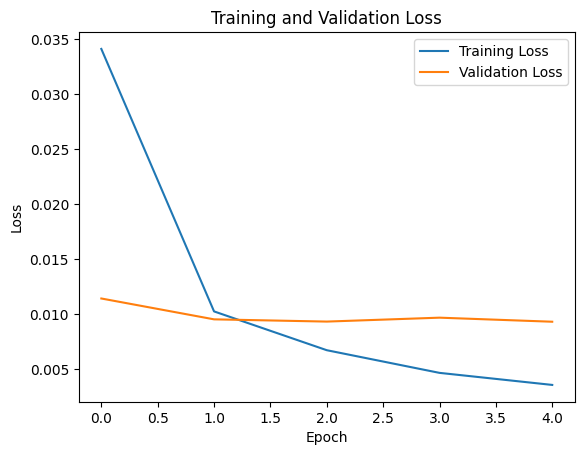

In [11]:
log_dir = "lightning_logs/version_0"
y1_key = "train_loss"
y2_key = "val_loss"

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps = {x.step for x in event_accumulator.Scalars("epoch")}
x = list(range(len(steps)))
y1 = [x.value for x in event_accumulator.Scalars(y1_key) if x.step in steps]
y2 = [x.value for x in event_accumulator.Scalars(y2_key) if x.step in steps]

# Plot losses
plt.plot(y1, label='Training Loss')
plt.plot(y2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Bert-base-cased

In [12]:
MODEL_NAME = "bert-base-cased"
bert_data_module = BERTDataModule(texts, labels, batch_size, max_length, num_workers)
bert_model = BERTClassifier()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [13]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/bert-base-cased/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

trainer = pl.Trainer(max_epochs=5, detect_anomaly=True, callbacks=callbacks)
trainer.fit(bert_model, bert_data_module)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | bert    | BertModel | 108 M 
1 | linear1 | Linear    | 38.5 K


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 372: 'val_loss' reached 0.01171 (best 0.01171), saving model to '/content/checkpoint/bert-base-cased/epoch=0-step=372.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 744: 'val_loss' reached 0.00974 (best 0.00974), saving model to '/content/checkpoint/bert-base-cased/epoch=1-step=744.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1116: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1488: 'val_loss' reached 0.00916 (best 0.00916), saving model to '/content/checkpoint/bert-base-cased/epoch=3-step=1488.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1860: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
trainer.test(bert_model, bert_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.009400189854204655    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.009400189854204655}]

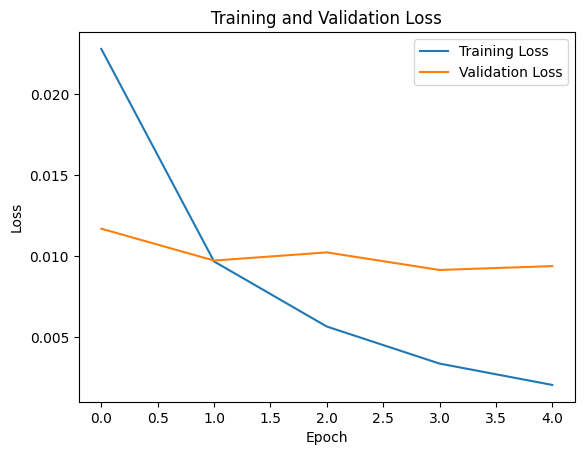

In [15]:
log_dir = "lightning_logs/version_1"
y3_key = "train_loss"
y4_key = "val_loss"

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps = {x.step for x in event_accumulator.Scalars("epoch")}
x = list(range(len(steps)))
y3 = [x.value for x in event_accumulator.Scalars(y3_key) if x.step in steps]
y4 = [x.value for x in event_accumulator.Scalars(y4_key) if x.step in steps]

# Plot losses
plt.plot(y3, label='Training Loss')
plt.plot(y4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Config BERTClassifier (Change the last layers)

In [16]:
class BERTClassifierConfig(pl.LightningModule):
    def __init__(self, learning_rate=2e-5):
        super(BERTClassifierConfig, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.linear1 = torch.nn.Linear(self.bert.config.hidden_size, 100)
        self.linear2 = torch.nn.Linear(100, 50) # Set the last layers are 100, 50, 20, 10 respectively.
        self.linear3 = torch.nn.Linear(50, 20)
        self.linear4 = torch.nn.Linear(20, 10)
        self.linear5 = torch.nn.Linear(10, 1)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        #print(outputs.last_hidden_state.shape)
        linear1 = self.linear1(outputs.last_hidden_state[:, 0])
        linear2 = self.linear2(linear1)
        linear3 = self.linear3(linear2)
        linear4 = self.linear4(linear3)
        linear5 = self.linear5(linear4)
        return linear5

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        loss = F.mse_loss(predicted_value, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        val_loss = F.mse_loss(predicted_value, labels)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['label'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        test_loss = F.mse_loss(predicted_value, labels)
        self.log("test_loss", test_loss, on_step=False, on_epoch=True, prog_bar=True)
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


In [17]:
bert_data_module_2 = BERTDataModule(texts, labels, batch_size, max_length, num_workers)
bert_model_2 = BERTClassifierConfig()

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_loss",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

trainer = pl.Trainer(max_epochs=5, detect_anomaly=True, callbacks=callbacks)
trainer.fit(bert_model_2, bert_data_module_2)

INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/checkpoint exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | bert    | BertModel | 108 M 
1 | linear1 | Linear    | 76.9 K
2 | linear2 | Linear    | 5.0 K 
3 | linear3 | Linear    | 1.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 372: 'val_loss' reached 0.01238 (best 0.01238), saving model to '/content/checkpoint/epoch=0-step=372.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 744: 'val_loss' reached 0.00979 (best 0.00979), saving model to '/content/checkpoint/epoch=1-step=744.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1116: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1488: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1860: 'val_loss' reached 0.00895 (best 0.00895), saving model to '/content/checkpoint/epoch=4-step=1860.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [18]:
trainer.test(bert_model_2, bert_data_module_2)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.008952690288424492    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.008952690288424492}]

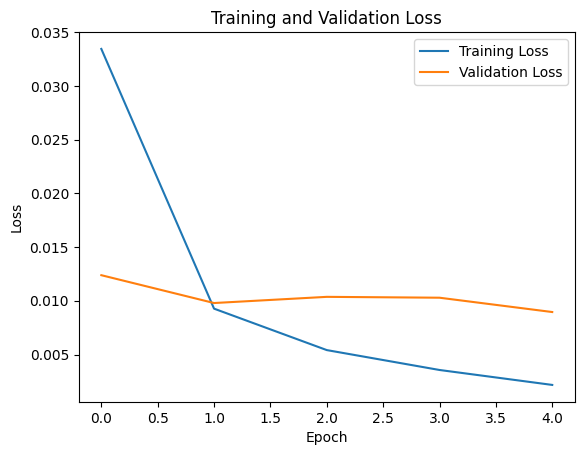

In [19]:
log_dir = "lightning_logs/version_2"
y5_key = "train_loss"
y6_key = "val_loss"

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps = {x.step for x in event_accumulator.Scalars("epoch")}
x = list(range(len(steps)))
y5 = [x.value for x in event_accumulator.Scalars(y5_key) if x.step in steps]
y6 = [x.value for x in event_accumulator.Scalars(y6_key) if x.step in steps]

# Plot losses
plt.plot(y5, label='Training Loss')
plt.plot(y6, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Summary

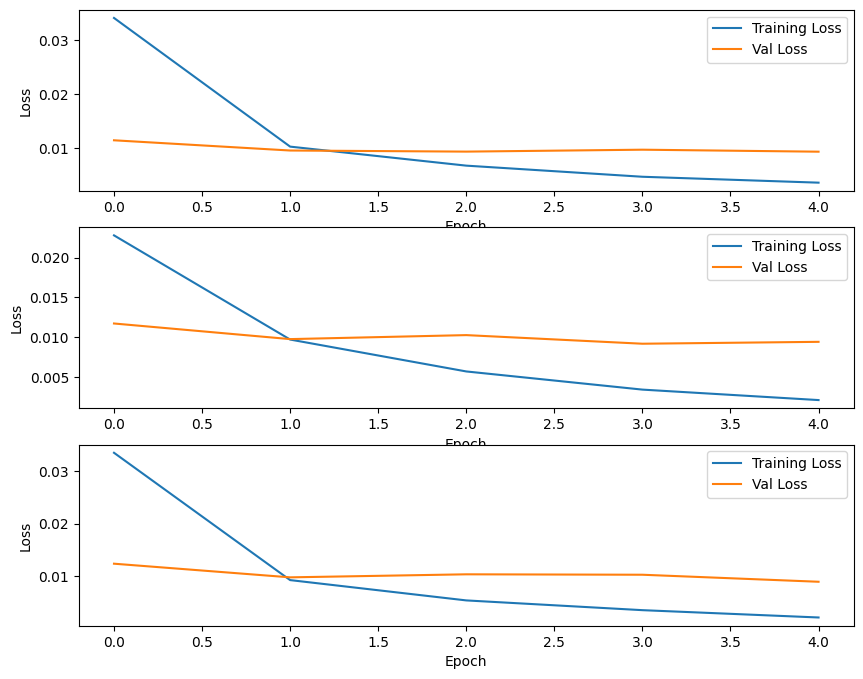

In [24]:
# Create figure and axis objects
fig, axs = plt.subplots(3, figsize = (10,8))

# Plot data on each axis
axs[0].plot(y1, label='Training Loss')
axs[0].plot(y2, label='Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(y3, label='Training Loss')
axs[1].plot(y4, label='Val Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(y5, label='Training Loss')
axs[2].plot(y6, label='Val Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()

# Show plot
plt.show()